# **Medical VQA**

This notebook is mostly [uakarsh](https://github.com/uakarsh/)'s work with some alterations.(altered some functions, changed model structure and hyperparametes, and Added test results). his work is inspired ( but not a full-application ) of this [paper](https://arxiv.org/pdf/1511.02274.pdf).

data desciption can be found in the EDA notebook. 



### **Workflow:**
1. Data preprocessing is performed on questions ( for embedding) and images ( to extract feauters).

2. image features are extracted from the last Vgg16 pooling layer,Each feature vector corresponds to a 32 x 32 pixel region.

3. Extracted feauters are combined into one dataset.

4. model is built using that dataset. question vectores are inputed through LSTM before concatenation.

5. General VQA model structure: cnn(for image), LSTM(for questions) => concatenate => flatten => output a propabalistc prediction. 


## **Network Architecture**





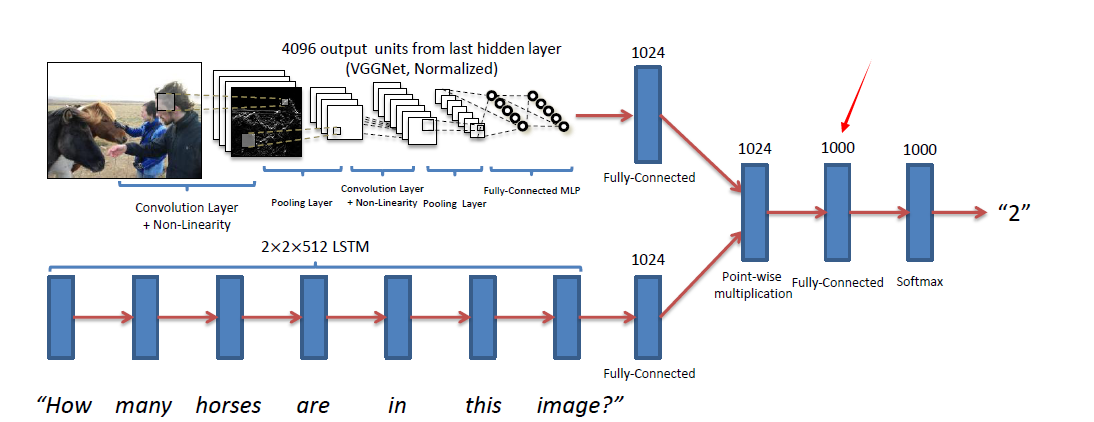

## Imports 

In [ ]:
import json
import h5py
import numpy as np
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import scipy.io
import pdb
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras,h5py
import pandas as pd
import os
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import keras.activations
import keras.backend as kbe
from pprint import pprint
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras import regularizers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate
from keras.utils.vis_utils import plot_model
from keras.layers import BatchNormalization 
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **Data Preprocessing**

## Question Embedding 

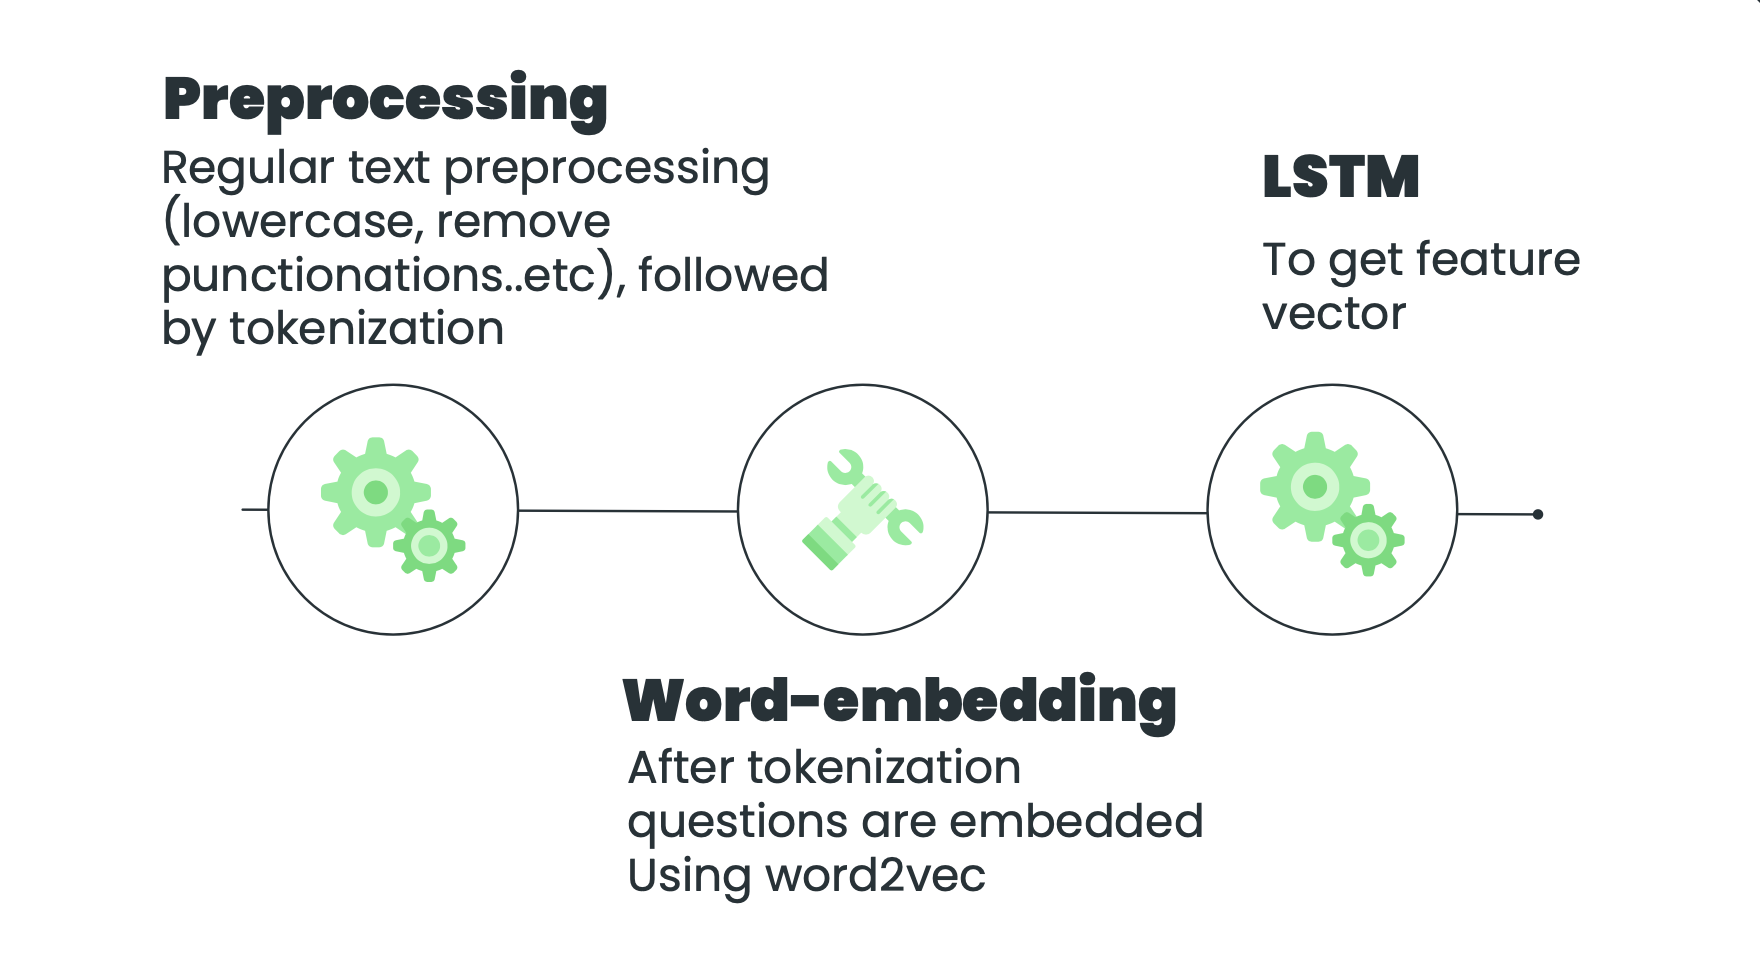

In [ ]:
model_path = '/content/drive/MyDrive/work/DL_VQA/GoogleNews-vectors-negative300.bin.gz'            # Path where the model is stored
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)            # Loading the model using gensim

In [ ]:



def extract_feat(doc):
  feat = []
  for word in doc:
    try:
      feat.append(model_w2v[word])
    except:
      pass
  return feat

def tokenize(sentence):
    return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

def prepro_question(imgs, method):
    s = img['question'].lower()
    if method == 'nltk':
      txt = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', s)  #Replace punctuation with space. Careful since punctuation can sometime be useful
      txt= re.sub('\s+', ' ', txt)  #Remove extra space and tabs
      txt = word_tokenize(s)
    else:
      txt = tokenize(s)
    
  
    return txt 


def get_top_answers(imgs, num_ans):

    """
    Print the questions and returns the time, one answer is repeated
    """
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower()  # If the string is a number, it would result into error
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    print('top answer and their counts:') 
    print('\n'.join(map(str,cw[:20])))
    
    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]



In [ ]:
imgs_train = json.load(open('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/trainset.json' , 'r'))# Unnnecesarily, i have used the same file two times

num_ans = 476
top_ans = get_top_answers(imgs_train, num_ans)                         
atoi = {w:i for i,w in enumerate(top_ans)}                   # Word : Count
itoa = {i:w for i,w in enumerate(top_ans)}                   # Count : Word
feat_dim = 300                                               # 300 Dimensional Vector
imgs_data_train = json.load(open('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/trainset.json' , 'r'))  # trainset.json
num_ans = 10    
method = 'nltk'
max_length = 21                       # Max Length of the question
dir_path = "/content/drive/MyDrive/work/DL_VQA/med-vqa-main/QA/"    # The path where we will be storing .h5 file
N = len(imgs_data_train)

image_path = '/content/drive/MyDrive/work/DL_VQA/med-vqa-main/VQA_RAD Image Folder/'


In [ ]:

def save_data(imgs_data_train,dir_path):
    
 
        for i,img in enumerate(imgs_data_train):
            #print('X' , img['ques_id'])
            img_path = image_path+img['image_name']  

            s = img['question']
            print(i,s)   # Print the number and the question
          
            img['processed_tokens'] = prepro_question(s, method)           
            question_id = img['qid']
            feat = np.array(extract_feat(img['processed_tokens']))
            label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32')
            label_length = min(max_length, len(feat)) # record the length of this sequence
            label_arrays[0, :label_length, :] = feat
            try:
                ans_arrays = atoi[img['answer'].lower()]
            except :
                ans_arrays = atoi[str(img['answer'])]

            f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w")
            f.create_dataset("ques_train", dtype='float32', data=label_arrays)
            f.create_dataset("answers", dtype='uint32', data=ans_arrays)
            f.close()
        return    
 


In [ ]:
data = save_data()

## **Image Model**

* this part is done following the steps in the following [slides](http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf)

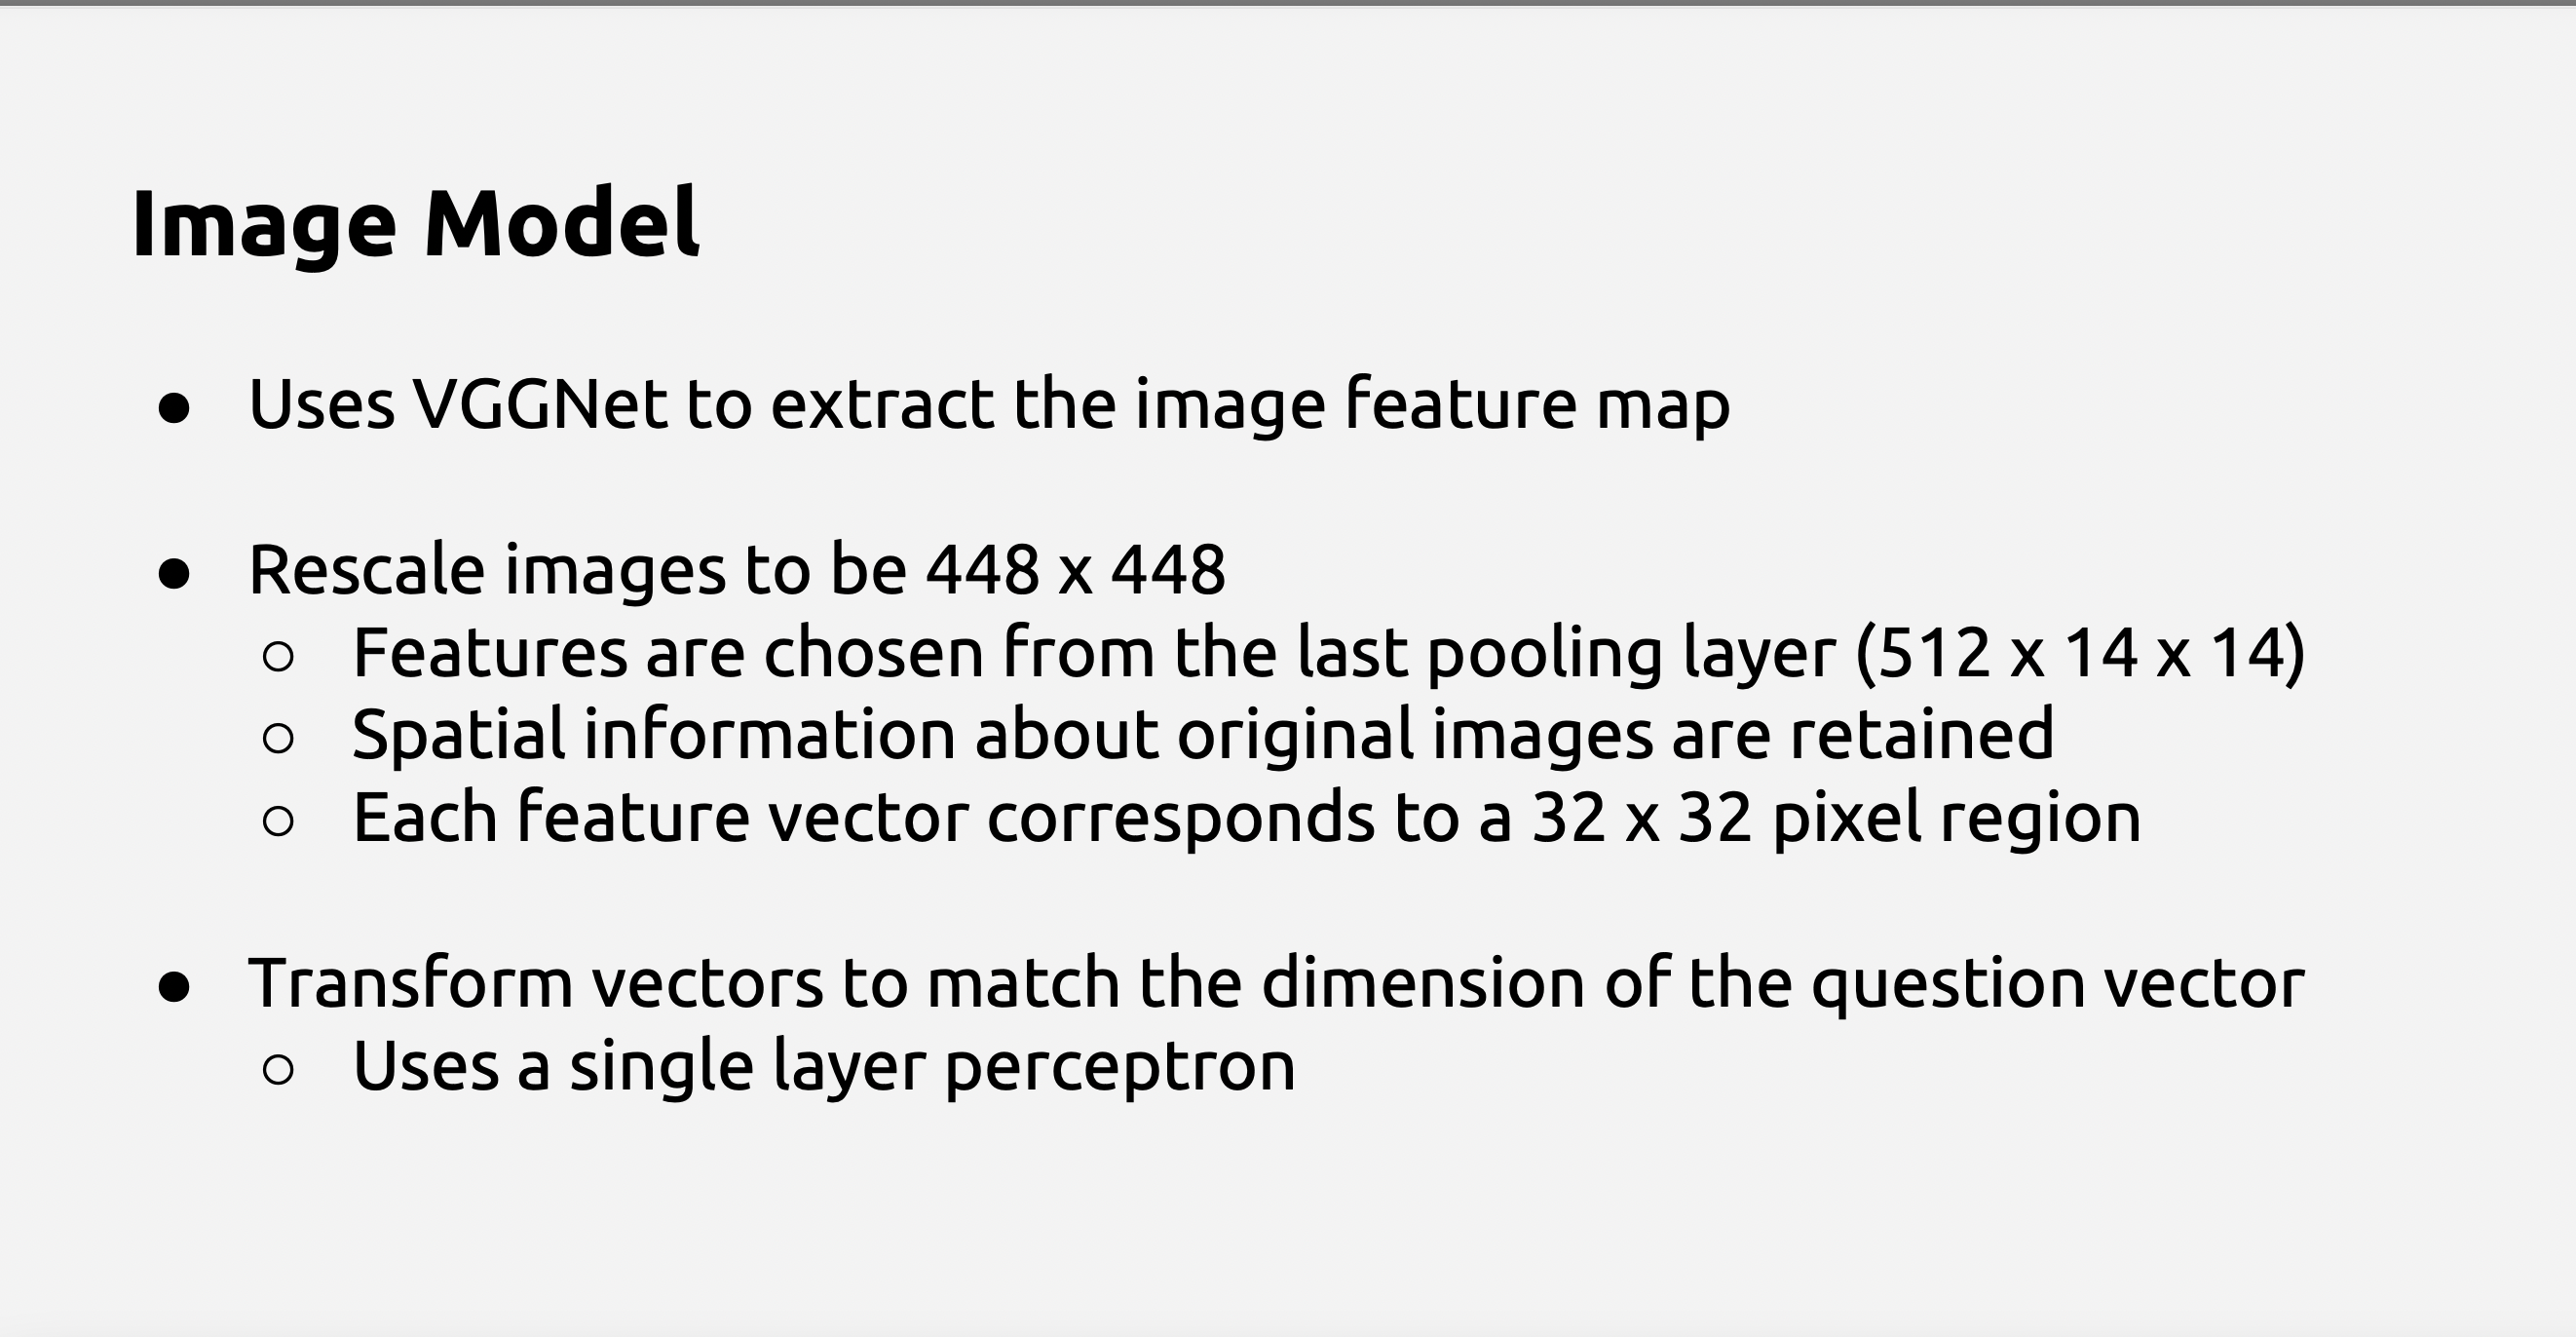

In [ ]:
def image_layer(input_shape):
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False,weights='imagenet')
    base_model.trainable = False # Do not train it
    x = base_model.layers[-2].output  # Shape would be (28*28*512)
    x = tf.reshape(x , [-1,x.shape[2]*x.shape[1] , x.shape[3]]) # Shape would be (1,784,512)
    x = tf.keras.layers.Dense(1024)                            # This step can be found out in the slides, that after feature extraction, they are connecting a dense layer, slide - 6 (Transform into a same size vector)
    return x

def vgg_preprocessing(model,image):
  return model(image)


In [ ]:

def load_data():

        images = []
        questions = []
        answers = []
        ids = []
 
        data = imgs_data_train   # trainset.json
        model = image_layer(input_shape = (448,448,3)) # Making VGG16 Model
        for i,img in enumerate(data):
        
            img_path = img['image_name']  # Image Name
            question_id = img['qid']      # Question id
            
            with h5py.File(os.path.join(dir_path,str(question_id) + '.h5'),'r') as hf:
                question = hf['.']['ques_train'][()] # Embedded question
                answer = hf['.']['answers'][()]       # Embedded answer
         
            image = cv2.imread('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/VQA_RAD Image Folder/'+img_path , cv2.IMREAD_COLOR) # Reading the image
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (448,448)) # Reshape
            images.append(image)
            questions.append(np.array(question))
            answers.append(np.array(answer))
            ids.append(question_id)     
            if i%100==0:
              print("Processed =>",i,' which is',round(100*i/len(data),2),'%')          
        
        questions = np.reshape(np.array(questions) , [-1,max_length,feat_dim])
        return (np.array(images) , questions ,np.array(answers) , np.array(ids))


top answer and their counts:
(884, 'no')
(829, 'yes')
(35, 'right')
(31, 'axial')
(23, 'left')
(15, 'fat')
(14, 'pa')
(12, 'right lung')
(12, 'pancreas')
(12, 'one')
(11, 'left kidney')
(11, 'diffuse')
(10, 'right upper lobe')
(10, 'right sided pleural effusion')
(10, 'right side')
(10, 'ct')
(10, 'brain')
(9, 'lateral ventricles')
(9, 'bilateral')
(8, 'subarachnoid')


In [ ]:
datagen = load_data()   # Load the Data

58900480/58889256 [==============================] - 0s 0us/step
Processed => 0  which is 0.0 %
Processed => 100  which is 3.26 %
Processed => 200  which is 6.53 %
Processed => 300  which is 9.79 %
Processed => 400  which is 13.05 %
Processed => 500  which is 16.32 %
Processed => 600  which is 19.58 %
Processed => 700  which is 22.85 %
Processed => 800  which is 26.11 %
Processed => 900  which is 29.37 %
Processed => 1000  which is 32.64 %
Processed => 1100  which is 35.9 %
Processed => 1200  which is 39.16 %
Processed => 1300  which is 42.43 %
Processed => 1400  which is 45.69 %
Processed => 1500  which is 48.96 %
Processed => 1600  which is 52.22 %
Processed => 1700  which is 55.48 %
Processed => 1800  which is 58.75 %
Processed => 1900  which is 62.01 %
Processed => 2000  which is 65.27 %
Processed => 2100  which is 68.54 %
Processed => 2200  which is 71.8 %
Processed => 2300  which is 75.07 %
Processed => 2400  which is 78.33 %
Processed => 2500  which is 81.59 %
Processed => 2600 

### Creating the Dataset: We do this, by renaming the contents of .h5 file

In [ ]:
images,questions,answers,ids =datagen[0],datagen[1],datagen[2],datagen[3]
print("Images have a size of:",images.shape)
print("Questions have a size of:",questions.shape)
print("Answers have a size of:",answers.shape)
print("Ids have a size of:",ids.shape)
dir_path = r'/content/drive/MyDrive/work/DL_VQA/med-vqa-main/QA/' # The directory where the .h5 file for each entry is saved
m = 100
for i in range(images.shape[0]):
    ans_array = answers[i]
    image_array = images[i]
    quest_array = questions[i]
    question_id = ids[i]
    f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w") # Loading the 'h5 file
    f.create_dataset("ques_train", dtype='float32', data=quest_array) # Question Embedding
    f.create_dataset("image_vector", dtype='float32', data=image_array) # Image Embedding (Not preprocessed)
    f.create_dataset("answers", dtype='uint32', data=ans_array)      # Answers in embedded form
    f.close()
    if i%m ==0:
        print("Processed =>", i,' total percentage =>', round(100*i/images.shape[0],2),' %')
print("Your processing has been done")

Images have a size of: (3064, 448, 448, 3)
Questions have a size of: (3064, 21, 300)
Answers have a size of: (3064,)
Ids have a size of: (3064,)
Processed => 0  total percentage => 0.0  %
Processed => 100  total percentage => 3.26  %
Processed => 200  total percentage => 6.53  %
Processed => 300  total percentage => 9.79  %
Processed => 400  total percentage => 13.05  %
Processed => 500  total percentage => 16.32  %
Processed => 600  total percentage => 19.58  %
Processed => 700  total percentage => 22.85  %
Processed => 800  total percentage => 26.11  %
Processed => 900  total percentage => 29.37  %
Processed => 1000  total percentage => 32.64  %
Processed => 1100  total percentage => 35.9  %
Processed => 1200  total percentage => 39.16  %
Processed => 1300  total percentage => 42.43  %
Processed => 1400  total percentage => 45.69  %
Processed => 1500  total percentage => 48.96  %
Processed => 1600  total percentage => 52.22  %
Processed => 1700  total percentage => 55.48  %
Processed

## Preparing the data for model creation 

In [ ]:
import os,h5py
# Image Model
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
import warnings
warnings.filterwarnings('ignore')

'''  Preprocessing with the VGG 16 Model  '''

model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',
        input_shape=(448,448,3))
#print("The Last layer")
last_layer = model.layers[-1].output   # Last layer has an output layer of (14,14,512)
model = Model(model.input,last_layer)
model.trainable = False
# print(model.summary())
def extract_feature(image):
    ''' Preprocessing with VGG Netowrk'''
    image = model(image)
    return image  # Shape is (196,512)


dimen_red = tf.keras.Sequential() 
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1))) 
dimen_red.add(tf.keras.layers.Dense(21))
dimen_red.add(tf.keras.layers.Permute((2,1)))

train_dir = r'/content/drive/MyDrive/work/DL_VQA/med-vqa-main/QA/'
images = []
ans = []
ques = []
count = 0
content = os.listdir(train_dir)[:2300] 
length = len(content)
for i in content:
    # Reading the data
    file = h5py.File(train_dir+i)
    images.append(np.array(file['.']['image_vector'][()] ))
    ans.append(np.array(file['.']['answers'][()] ))
    ques.append(np.array(file['.']['ques_train'][()] ))
    count+=1
    if count%100 == 0:
      print("The count is:",count,"and the percentage proportion is:",round(100*count/length,2),'%')
images = tf.convert_to_tensor(np.array(images))   # For the GPU purpose
ans = tf.convert_to_tensor(np.array(ans))
ques = tf.convert_to_tensor(np.array(ques))

The count is: 100 and the percentage proportion is: 4.35 %
The count is: 200 and the percentage proportion is: 8.7 %
The count is: 300 and the percentage proportion is: 13.04 %
The count is: 400 and the percentage proportion is: 17.39 %
The count is: 500 and the percentage proportion is: 21.74 %
The count is: 600 and the percentage proportion is: 26.09 %
The count is: 700 and the percentage proportion is: 30.43 %
The count is: 800 and the percentage proportion is: 34.78 %
The count is: 900 and the percentage proportion is: 39.13 %
The count is: 1000 and the percentage proportion is: 43.48 %
The count is: 1100 and the percentage proportion is: 47.83 %
The count is: 1200 and the percentage proportion is: 52.17 %
The count is: 1300 and the percentage proportion is: 56.52 %
The count is: 1400 and the percentage proportion is: 60.87 %
The count is: 1500 and the percentage proportion is: 65.22 %
The count is: 1600 and the percentage proportion is: 69.57 %
The count is: 1700 and the percentag

Note: I tried using the whole dataset but google colab kept crashing and saying that I used up all avilable RAM, so I was only cabable of using 2300 samples, maybe if I used another preprocessing appraoch I'll be capable of doing so, I'll add this to my future work list.

In [ ]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(model(tf.reshape(j,[1,448,448,3])))  # It was not possible directly on GPU, hence had to use for loop
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l) )

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 4.35 %
The count is: 200 and the percentage proportion is: 8.7 %
The count is: 300 and the percentage proportion is: 13.04 %
The count is: 400 and the percentage proportion is: 17.39 %
The count is: 500 and the percentage proportion is: 21.74 %
The count is: 600 and the percentage proportion is: 26.09 %
The count is: 700 and the percentage proportion is: 30.43 %
The count is: 800 and the percentage proportion is: 34.78 %
The count is: 900 and the percentage proportion is: 39.13 %
The count is: 1000 and the percentage proportion is: 43.48 %
The count is: 1100 and the percentage proportion is: 47.83 %
The count is: 1200 and the percentage proportion is: 52.17 %
The count is: 1300 and the percentage proportion is: 56.52 %
The count is: 1400 and the percentage proportion is: 60.87 %
The count is: 1500 and the percentage proportion is: 65.22 %
The count is: 1600 and the percentage pro

In [ ]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(dimen_red(j))     # Making it to the same shape as that of question embedding
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l))

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 4.35 %
The count is: 200 and the percentage proportion is: 8.7 %
The count is: 300 and the percentage proportion is: 13.04 %
The count is: 400 and the percentage proportion is: 17.39 %
The count is: 500 and the percentage proportion is: 21.74 %
The count is: 600 and the percentage proportion is: 26.09 %
The count is: 700 and the percentage proportion is: 30.43 %
The count is: 800 and the percentage proportion is: 34.78 %
The count is: 900 and the percentage proportion is: 39.13 %
The count is: 1000 and the percentage proportion is: 43.48 %
The count is: 1100 and the percentage proportion is: 47.83 %
The count is: 1200 and the percentage proportion is: 52.17 %
The count is: 1300 and the percentage proportion is: 56.52 %
The count is: 1400 and the percentage proportion is: 60.87 %
The count is: 1500 and the percentage proportion is: 65.22 %
The count is: 1600 and the percentage pro

In [ ]:
images = tf.reshape(images,[length,21,300])
img = images  #Tensor containing images
que = ques  # Tensor containing question vector
img = img/255.0 # Normalizing

In [ ]:
que.shape,img.shape

(TensorShape([2300, 21, 300]), TensorShape([2300, 21, 300]))

In [ ]:
''' The below mentioned two Input objects of keras will be useful for making the model '''

ques = tf.keras.layers.Input((21,300))  # Input Model (for ques)
images = tf.keras.layers.Input((21,300)) # Input Model (for images)

## The Model 

In [ ]:
#------------adding dense layers to image model-------------
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(imagica)
#------------LSTM-------------
quesa = LSTM(512,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'tanh')(quesa)
quesa = Dropout(0.2)(quesa)
quesa = Dense(512, activation = 'tanh')(quesa)
quesa = Dropout(0.2)(quesa)
quesa= Dense(320,kernel_regularizer=regularizers.l1(0.01))(quesa)
#------------concatenation-------------
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(476,activation='softmax')(quesa) 

## Plotting the Model

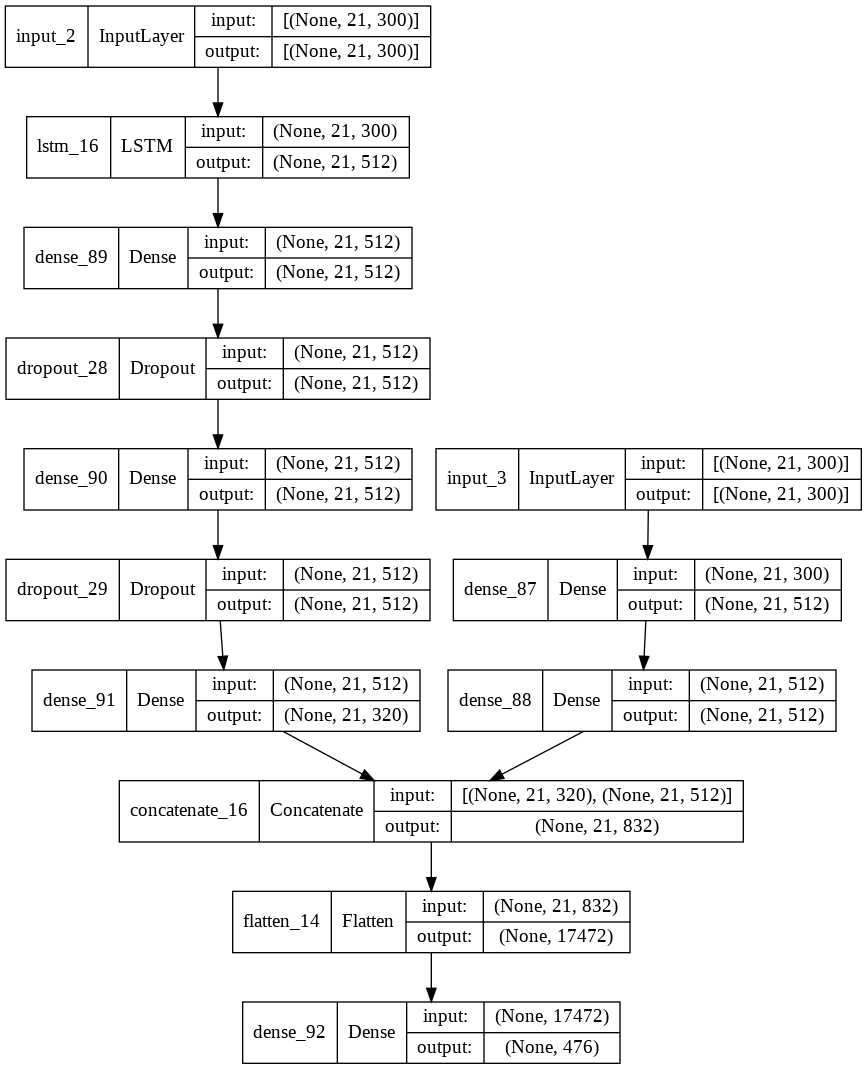

In [ ]:
from keras.utils.vis_utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Note: I didn't use this model becuases I changed the shape of the questions vector before concatenation and I don't think this step is vaild, they should be the same shape, so I stuck to this architecture, with a dropout of 0.3:

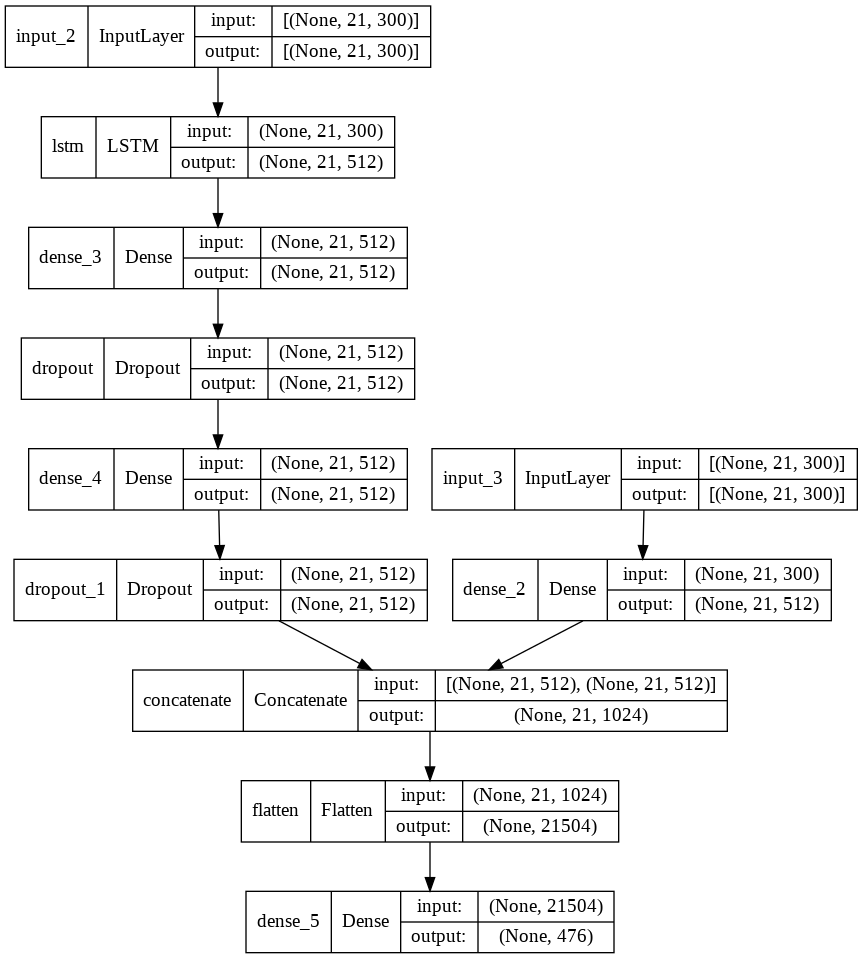

## Compiling and fitting the model

In [ ]:
f1 = tfa.metrics.F1Score(36,'micro' or 'macro')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
answers = tf.keras.utils.to_categorical(ans)
answers.shape

(2300, 475)

In [ ]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 21, 300)]    0           []                               
                                                                                                  
 lstm_16 (LSTM)                 (None, 21, 512)      1665024     ['input_2[0][0]']                
                                                                                                  
 dense_89 (Dense)               (None, 21, 512)      262656      ['lstm_16[0][0]']                
                                                                                                  
 dropout_28 (Dropout)           (None, 21, 512)      0           ['dense_89[0][0]']               
                                                                                           

In [ ]:
model.fit([img,que],ans,epochs = 20,batch_size=16,verbose=1,validation_split=0.2)

Epoch 1/20
115/115 [==============================] - 3s 14ms/step - loss: 21.7094 - accuracy: 0.3413 - val_loss: 3.5017 - val_accuracy: 0.3804
Epoch 2/20
115/115 [==============================] - 1s 9ms/step - loss: 1.8360 - accuracy: 0.5652 - val_loss: 3.9925 - val_accuracy: 0.3717
Epoch 3/20
115/115 [==============================] - 1s 9ms/step - loss: 1.1912 - accuracy: 0.7299 - val_loss: 4.7116 - val_accuracy: 0.3739
Epoch 4/20
115/115 [==============================] - 1s 9ms/step - loss: 0.9403 - accuracy: 0.8185 - val_loss: 4.6810 - val_accuracy: 0.3783
Epoch 5/20
115/115 [==============================] - 1s 9ms/step - loss: 0.8068 - accuracy: 0.8723 - val_loss: 4.9622 - val_accuracy: 0.4239
Epoch 6/20
115/115 [==============================] - 1s 9ms/step - loss: 0.7220 - accuracy: 0.8995 - val_loss: 4.9225 - val_accuracy: 0.4283
Epoch 7/20
115/115 [==============================] - 1s 9ms/step - loss: 0.5535 - accuracy: 0.9375 - val_loss: 5.2821 - val_accuracy: 0.4304
Epoc

## Saving the Model for inference 

In [ ]:
model.save('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/results')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/work/DL_VQA/med-vqa-main/results/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/work/DL_VQA/med-vqa-main/results/assets


# Test Results 

## Preprocessing Test Data 

In [ ]:

imgs_test = json.load(open('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/testset.json' , 'r'))

num_ans = 476
top_ans = get_top_answers(imgs_test, num_ans)                         
atoi = {w:i for i,w in enumerate(top_ans)}                   # Word : Count
itoa = {i:w for i,w in enumerate(top_ans)}                   # Count : Word
feat_dim = 300                                               # 300 Dimensional Vector
num_ans = 10   
method = 'nltk'
max_length = 21   # Max Length of the question
dir_path = "/content/drive/MyDrive/work/DL_VQA/med-vqa-main/QA_test/"    # The path where we will be storing .h5 file
N = len(imgs_test)

image_path = '/content/drive/MyDrive/work/DL_VQA/med-vqa-main/VQA_RAD Image Folder/'

top answer and their counts:
(133, 'no')
(118, 'yes')
(12, 'axial')
(6, 'right')
(6, 'left')
(5, 'brain')
(4, 'right upper lobe')
(4, 'mri')
(4, 'female')
(3, 'right side')
(3, 'one')
(3, 'middle mogul')
(3, 'ct')
(3, 'abnormal')
(2, 'stomach')
(2, 'soft tissue mass in the region of the terminal ileum with mesenteric lymphadenopathy')
(2, 'right temporal lobe')
(2, 'right lung')
(2, 'right lower lateral lung field')
(2, 'right hemisphere')


In [ ]:
test_data = save_data(imgs_test)

0 Is there evidence of an aortic aneurysm?
1 Is there airspace consolidation on the left side?
2 Is this an axial plane?
3 How is the patient oriented?
4 Is there vascular pathology in this image?
5 Is there cardiomyopathy?
6 Are >12 ribs present in the image?
7 does this represent adequate inspiratory effort?
8 Is there a rib fracture?
9 Is there evidence of any fractures of the ribs?
10 Is there any intraparenchymal abnormalities in the lung fields?
11 Is there evidence of any abnormalities of the lung parenchyma?
12 Is there evidence of small bowel obstruction on this image?
13 Is there small bowel thickening present?
14 was the patient positioned appropriately 	without tilting?
15 is the small bowel appropriately identified with GI contrast?
16 Is there a small bowel obstruction?
17 Are there hyper attenuating material along the aortic walls?
18 are there calcifications present on the abdominal aorta?
19 Does this patient have evidence of pneumoperitoneum?
20 Is there evidence of a

In [ ]:

def load_test_data():
        images = []
        questions = []
        answers = []
        ids = []

        data = imgs_test   # trainset.json
        model = image_layer(input_shape = (448,448,3)) # Making VGG16 Model
        for i,img in enumerate(data):
        
            img_path = img['image_name']  # Image Name
            question_id = img['qid']      # Question id
            with h5py.File(os.path.join('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/QA_test/',str(question_id) + '.h5'),'r') as hf:
                question = hf['.']['ques_train'][()] # Embedded question
                answer = hf['.']['answers'][()]       # Embedded answer
         
            image = cv2.imread('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/VQA_RAD Image Folder/'+img_path , cv2.IMREAD_COLOR) # Reading the image
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (448,448)) # Reshape

            images.append(image)
            questions.append(np.array(question))
            answers.append(np.array(answer))
            ids.append(question_id)     
            if i%100==0:
              print("Processed =>",i,' which is',round(100*i/len(data),2),'%')          
        
        questions = np.reshape(np.array(questions) , [-1,max_length,feat_dim])
        return (np.array(images) , questions ,np.array(answers) , np.array(ids))


In [ ]:

test_datagen = load_test_data()   # Load the Data

Processed => 0  which is 0.0 %
Processed => 100  which is 22.17 %
Processed => 200  which is 44.35 %
Processed => 300  which is 66.52 %
Processed => 400  which is 88.69 %


In [ ]:
imagest,questionst,answerst,idst =test_datagen[0],test_datagen[1],test_datagen[2],test_datagen[3]
print("Images have a size of:",imagest.shape)
print("Questions have a size of:",questionst.shape)
print("Answers have a size of:",answerst.shape)
print("Ids have a size of:",idst.shape)
m = 100
for i in range(imagest.shape[0]):
    ans_array = answerst[i]
    image_array = imagest[i]
    quest_array = questionst[i]
    question_id = idst[i]
    f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w") # Loading the 'h5 file
    f.create_dataset("ques_test", dtype='float32', data=quest_array) # Question Embedding
    f.create_dataset("image_vector", dtype='float32', data=image_array) # Image Embedding (Not preprocessed)
    f.create_dataset("answers", dtype='uint32', data=ans_array)      # Answers in embedded form
    f.close()
    if i%m ==0:
        print("Processed =>", i,' total percentage =>', round(100*i/imagest.shape[0],2),' %')
print("Your processing has been done")

Images have a size of: (451, 448, 448, 3)
Questions have a size of: (451, 21, 300)
Answers have a size of: (451,)
Ids have a size of: (451,)
Processed => 0  total percentage => 0.0  %
Processed => 100  total percentage => 22.17  %
Processed => 200  total percentage => 44.35  %
Processed => 300  total percentage => 66.52  %
Processed => 400  total percentage => 88.69  %
Your processing has been done


In [ ]:

'''  Preprocessing with the VGG 16 Model  '''

model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',
        input_shape=(448,448,3))
last_layer = model.layers[-1].output   # Last layer has an output layer of (14,14,512)
model = Model(model.input,last_layer)
model.trainable = False
# print(model.summary())
def extract_feature(image):
    ''' Preprocessing with VGG Netowrk'''
    image = modelt(image)
    return image  # Shape is (196,512)

'''  The below model will convert (196,512) to (21,300) (i.e same as the dimension of word embedding)  '''

dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(21))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

test_dir = '/content/drive/MyDrive/work/DL_VQA/med-vqa-main/QA_test/'# Containing .h5 file
imagest = []
anst = []
quest = []
count = 0
content = os.listdir(test_dir)   # The GPU Memory became full after this, hence had to take just these much samples :(
length = len(content)
for i in content:
    # Reading the data
    file = h5py.File(train_dir+i)
    imagest.append(np.array(file['.']['image_vector'][()] ))
    anst.append(np.array(file['.']['answers'][()] ))
    quest.append(np.array(file['.']['ques_test'][()] ))
    count+=1
    if count%100 == 0:
      print("The count is:",count,"and the percentage proportion is:",round(100*count/length,2),'%')


The count is: 100 and the percentage proportion is: 22.17 %
The count is: 200 and the percentage proportion is: 44.35 %
The count is: 300 and the percentage proportion is: 66.52 %
The count is: 400 and the percentage proportion is: 88.69 %


TypeError: ignored

In [ ]:
imagest = tf.convert_to_tensor(np.array(imagest))   # For the GPU purpose
anst = tf.convert_to_tensor(np.array(anst))
quest = tf.convert_to_tensor(np.array(quest))

In [ ]:
l = []
length = imagest.shape[0]
for i,j in enumerate(imagest):
  l.append(modelt(tf.reshape(j,[1,448,448,3])))  # It was not possible directly on GPU, hence had to use for loop
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
imagest = tf.convert_to_tensor(np.array(l) )

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 22.17 %
The count is: 200 and the percentage proportion is: 44.35 %
The count is: 300 and the percentage proportion is: 66.52 %
The count is: 400 and the percentage proportion is: 88.69 %


In [ ]:
l = []
length = imagest.shape[0]
for i,j in enumerate(imagest):
  l.append(dimen_red(j))     # Making it to the same shape as that of question embedding
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
imagest = tf.convert_to_tensor(np.array(l))

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 22.17 %
The count is: 200 and the percentage proportion is: 44.35 %
The count is: 300 and the percentage proportion is: 66.52 %
The count is: 400 and the percentage proportion is: 88.69 %


In [ ]:
imagest= tf.reshape(imagest,[length,21,300])
imgt = imagest  #Tensor containing images
quet = quest # Tensor containing question vector
imgt = imgt/255.0 # Normalizing

### Inference & Model Evaluation 

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/results/')

In [ ]:
prediction = tf.argmax(model.predict([imgt,quet]),axis=1).numpy()

In [ ]:
x = open('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/testset.json','r')
test = json.load(x)
test[0]

{'answer': 'yes',
 'answer_type': 'CLOSED',
 'image_name': 'synpic42202.jpg',
 'image_organ': 'CHEST',
 'phrase_type': 'freeform',
 'qid': 11,
 'question': 'Is there evidence of an aortic aneurysm?',
 'question_type': 'PRES'}

In [ ]:
import pickle
x = open('/content/drive/MyDrive/work/DL_VQA/med-vqa-main/cache/trainval_label2ans.pkl','rb')
a2lab = pickle.load(x)
import cv2
img_path = '/content/drive/MyDrive/work/DL_VQA/med-vqa-main/VQA_RAD Image Folder/'
import matplotlib.pyplot as plt

I wanted to try and test the model saparetly for open ended and closed ended questions, because I noticed that it performes better with closed ended questions, but I didn't have time to do that, so will add this to the future work list too.

In [ ]:
# Filter python objects with list comprehensions

open_dict = [x for x in test if x['answer_type'] == 'OPEN']
closed_dict = [x for x in test if x['answer_type'] == 'CLOSED']

# Transform python object back into json
open_json = json.dumps(open_dict)
closed_json = json.dumps(closed_dict)

In [ ]:
a2lab[prediction[2]]

'no'

Question: Is there evidence of an aortic aneurysm?
answer: Actual: yes predicted: yes
--------------------------------------------------


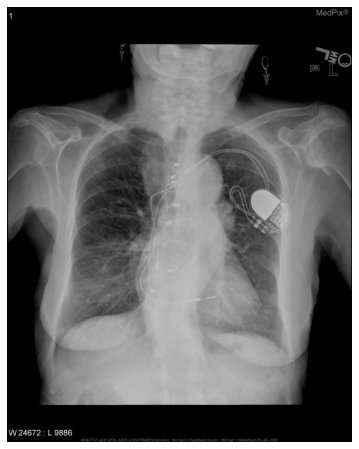

Question: Is there airspace consolidation on the left side?
answer: Actual: Yes predicted: yes
--------------------------------------------------


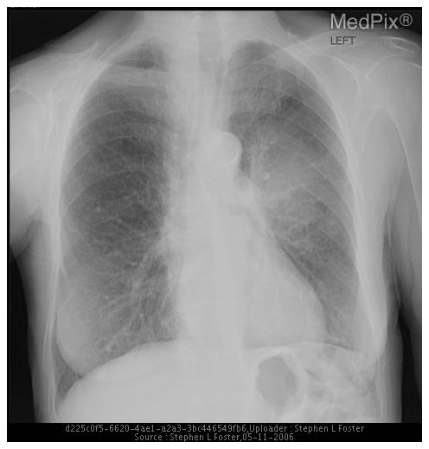

Question: Is this an axial plane?
answer: Actual: yes predicted: no
--------------------------------------------------


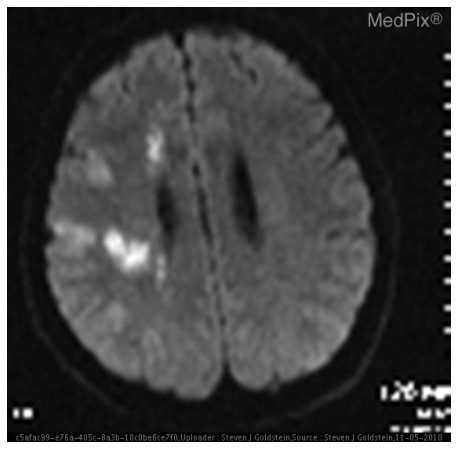

Question: How is the patient oriented?
answer: Actual: Posterior-Anterior predicted: ultrasound
--------------------------------------------------


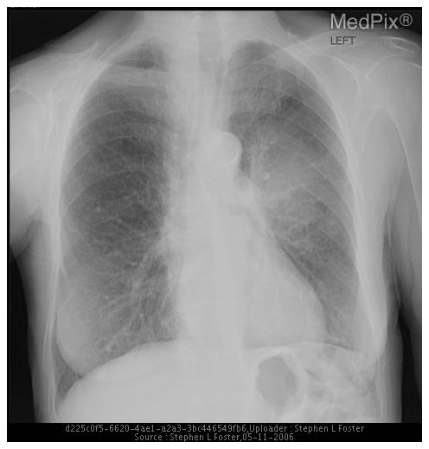

Question: Is there vascular pathology in this image?
answer: Actual: yes predicted: yes
--------------------------------------------------


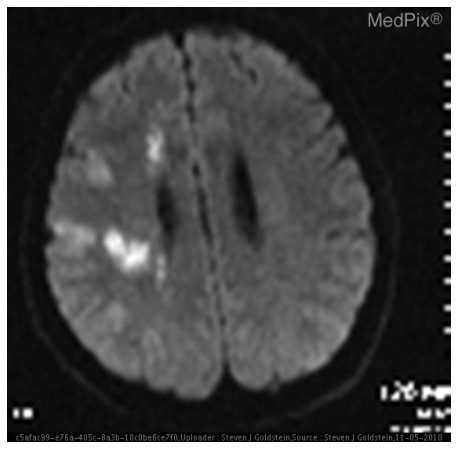

Question: Is there cardiomyopathy?
answer: Actual: yes predicted: yes
--------------------------------------------------


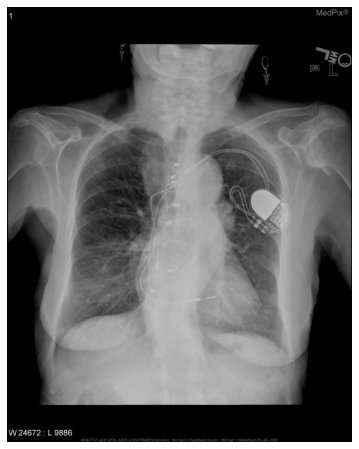

Question: Are >12 ribs present in the image?
answer: Actual: Yes predicted: no
--------------------------------------------------


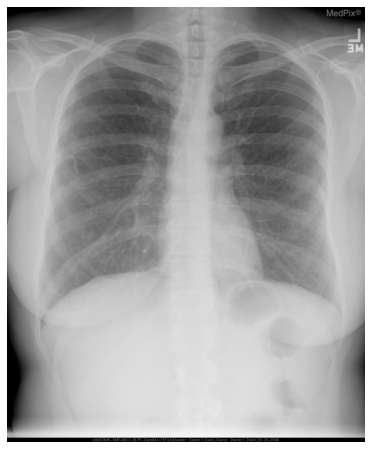

Question: does this represent adequate inspiratory effort?
answer: Actual: Yes predicted: no
--------------------------------------------------


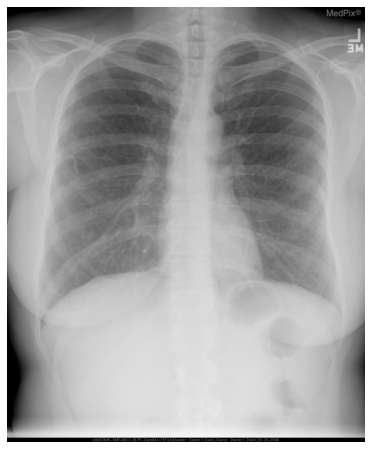

Question: Is there a rib fracture?
answer: Actual: No predicted: yes
--------------------------------------------------


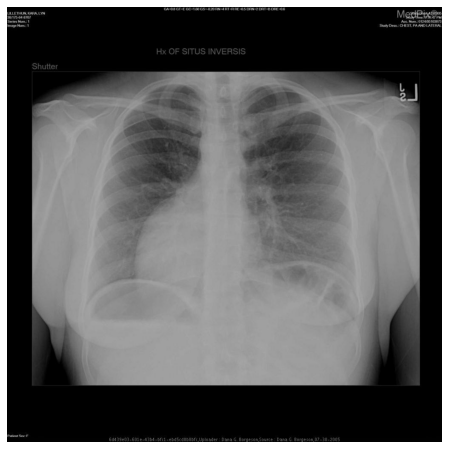

Question: Is there evidence of any fractures of the ribs?
answer: Actual: No predicted: yes
--------------------------------------------------


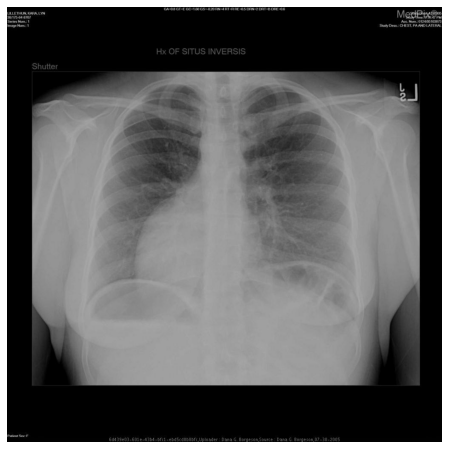

Question: Is there any intraparenchymal abnormalities in the lung fields?
answer: Actual: No predicted: yes
--------------------------------------------------


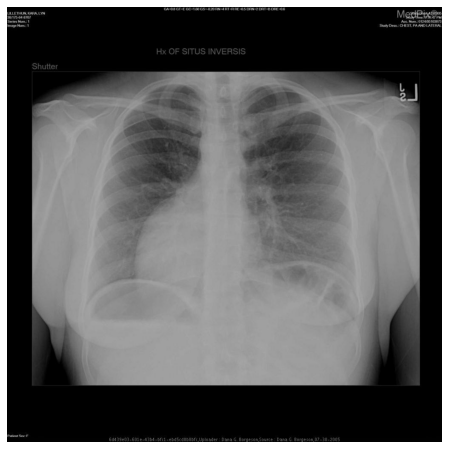

Question: Is there evidence of any abnormalities of the lung parenchyma?
answer: Actual: No predicted: yes
--------------------------------------------------


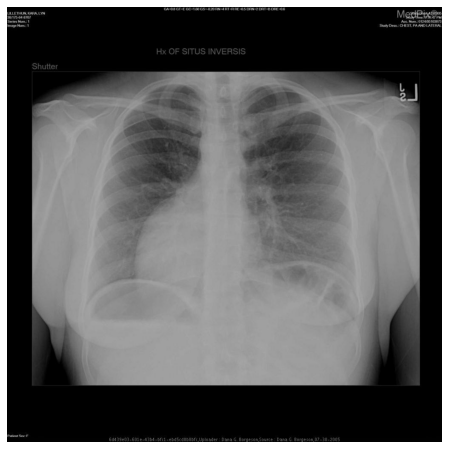

Question: Is there evidence of small bowel obstruction on this image?
answer: Actual: Yes predicted: yes
--------------------------------------------------


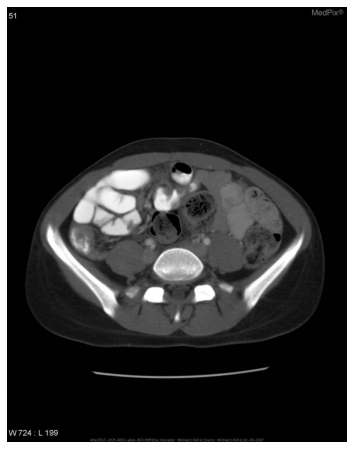

Question: Is there small bowel thickening present?
answer: Actual: Yes predicted: no
--------------------------------------------------


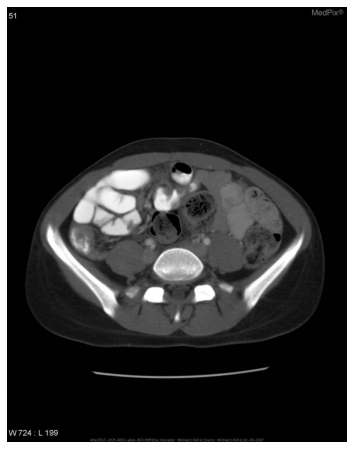

Question: was the patient positioned appropriately 	without tilting?
answer: Actual: yes predicted: yes
--------------------------------------------------


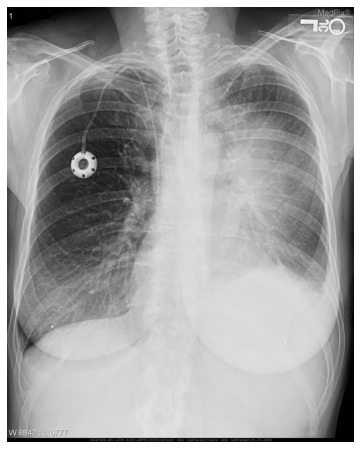

Question: is the small bowel appropriately identified with GI contrast?
answer: Actual: Yes predicted: yes
--------------------------------------------------


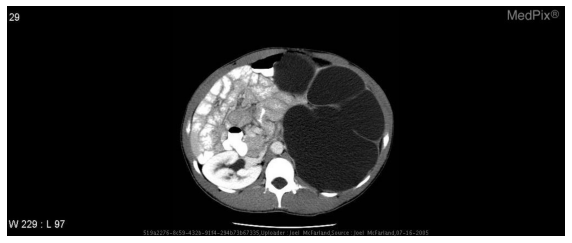

Question: Is there a small bowel obstruction?
answer: Actual: Yes predicted: yes
--------------------------------------------------


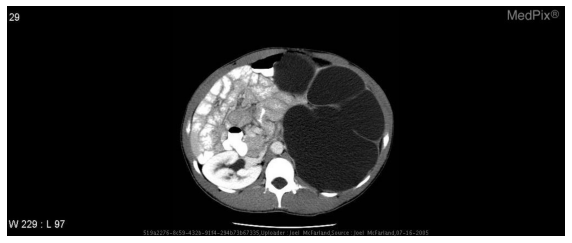

Question: Are there hyper attenuating material along the aortic walls?
answer: Actual: yes predicted: yes
--------------------------------------------------


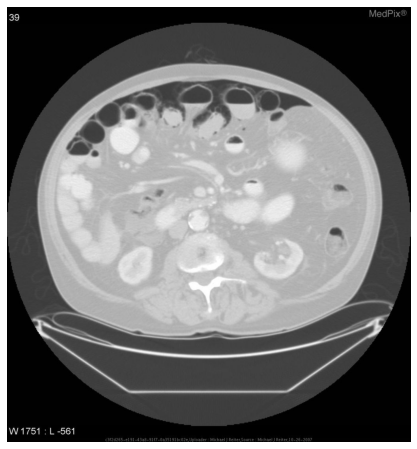

Question: are there calcifications present on the abdominal aorta?
answer: Actual: yes predicted: yes
--------------------------------------------------


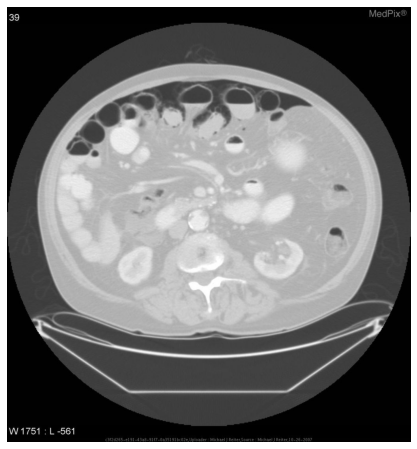

Question: Does this patient have evidence of pneumoperitoneum?
answer: Actual: No predicted: no
--------------------------------------------------


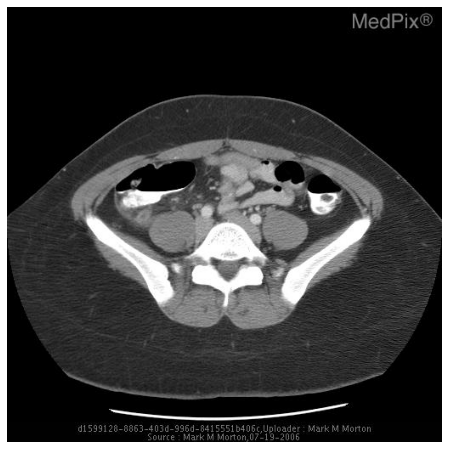

In [ ]:
for i in range(20):
  plt.figure(figsize=(10,8))
  image = cv2.imread(img_path+ test[i]['image_name'])
  plt.imshow(image)
  plt.show()
  value = "Actual: "+str(test[i]['answer'])+' predicted: '+ str(a2lab[prediction[i]])
  plt.axis('off')
  print("Question:",test[i]['question'])
  print("answer:",value)
  print("-"*50)


# Conclusion 

Using the baseline architecture with this dataset leads to overfitting, the dataset is small and imbalanced for such complicated task. The model performs better on close-ended questions, but it performs badly on open-ended ones, this could be improved by using more data and trying different architectures. 
